In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import numpy as np
import pandas as pd
import os
import gc
from tqdm import tqdm
from glob import glob
import seaborn as sns
import pprint as pp
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import np_utils
import itertools
import cv2
from PIL import Image
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
import keras.utils
from tensorflow.keras import utils as np_utils
#from keras.layers.normalization import BatchNormalization
from keras.preprocessing import image
from PIL import Image

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams["figure.dpi"] = 125
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.style.use('ggplot')
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams['image.cmap'] = 'gray' # grayscale looks better
from itertools import cycle
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [3]:
base_skin_dir = os.path.join('/Users/imtiazshishir/Desktop/Skin cancer')

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [4]:
data = pd.read_csv(os.path.join(base_skin_dir, '/Users/imtiazshishir/Desktop/Skin cancer/datafile.csv'))

# Creating New Columns for better readability

data['path'] = data['image_id'].map(imageid_path_dict.get)
data['cell_type'] = data['dx'].map(lesion_type_dict.get) 
data['cell_type_idx'] = pd.Categorical(data['cell_type']).codes

data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/Users/imtiazshishir/Desktop/Skin cancer/HAM10...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/Users/imtiazshishir/Desktop/Skin cancer/HAM10...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/Users/imtiazshishir/Desktop/Skin cancer/HAM10...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/Users/imtiazshishir/Desktop/Skin cancer/HAM10...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/Users/imtiazshishir/Desktop/Skin cancer/HAM10...,Benign keratosis-like lesions,2


<Axes: xlabel='cell_type'>

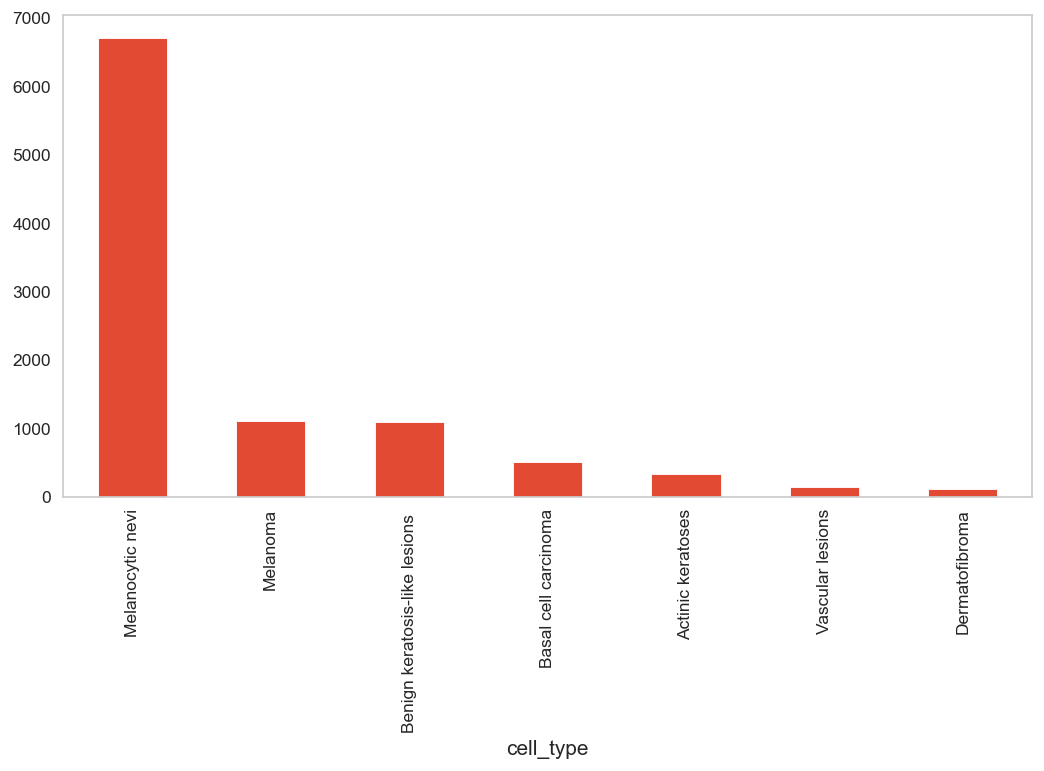

In [5]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
data['cell_type'].value_counts().plot(kind='bar', ax=ax1)

In [6]:
print(data['cell_type'].value_counts())

cell_type
Melanocytic nevi                  6705
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: count, dtype: int64


In [7]:
#image pre-processing
data['image'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((128,128))))

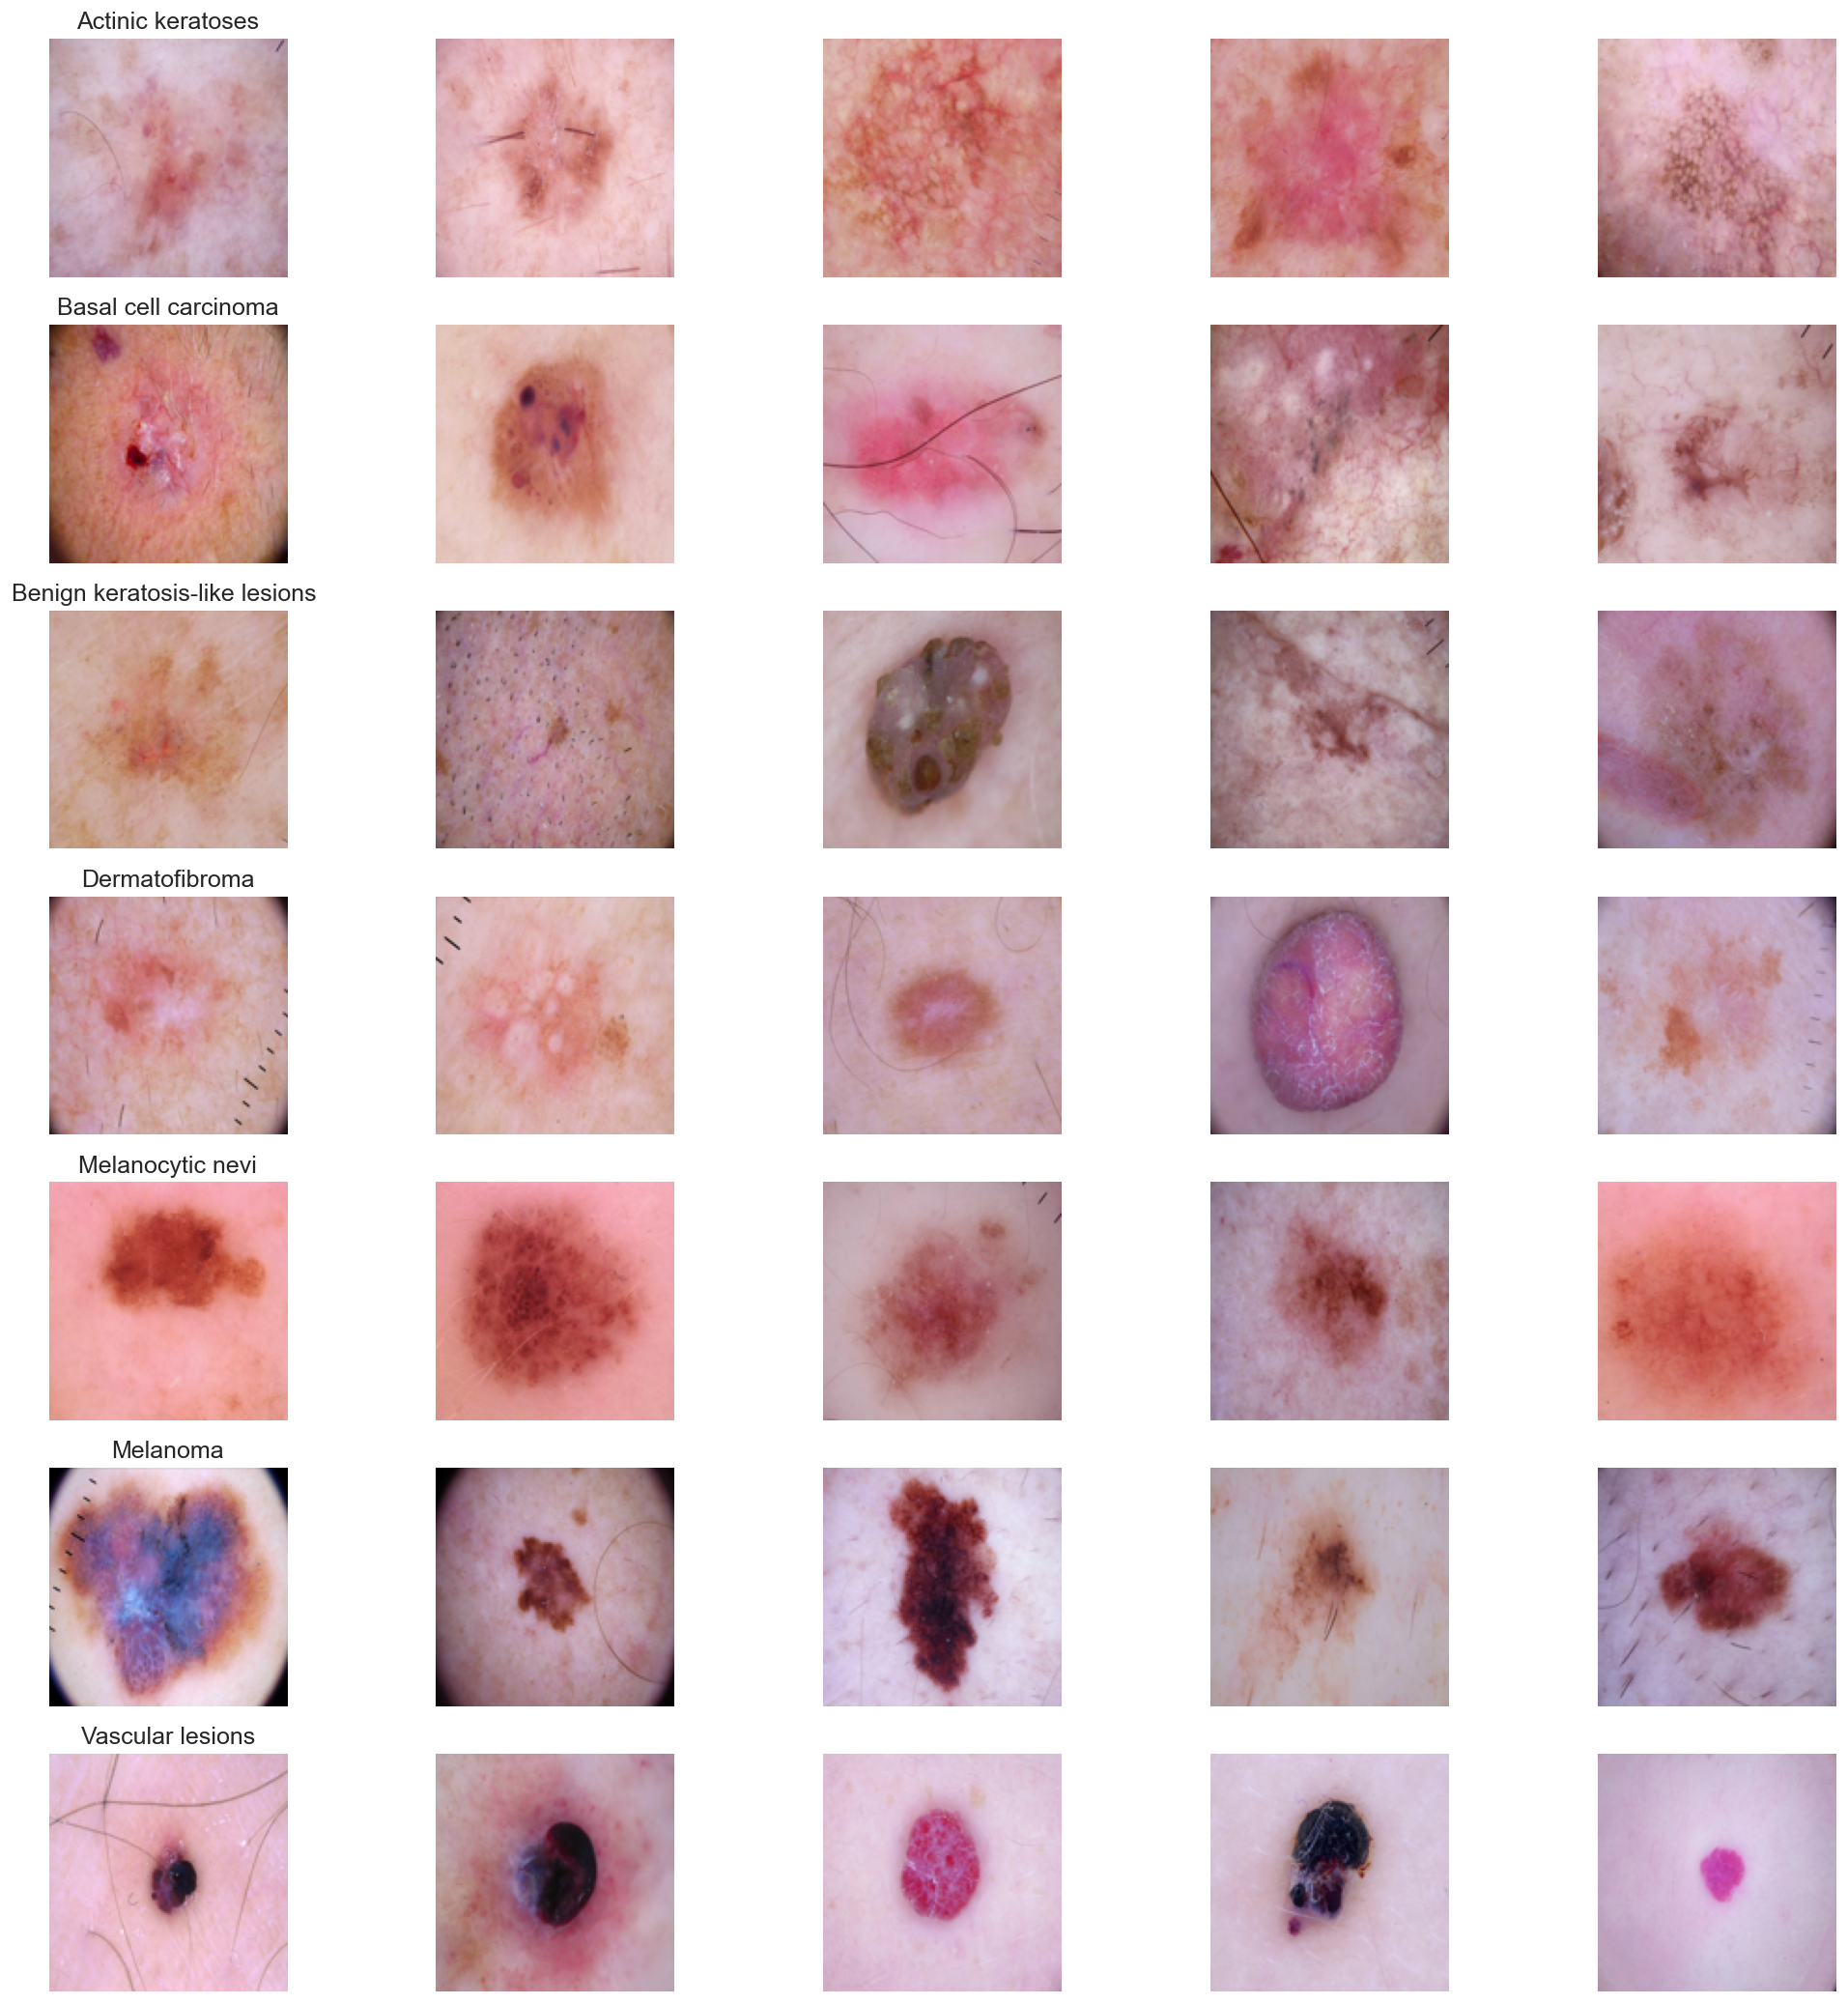

In [8]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         data.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [9]:
data['image'].map(lambda x: x.shape).value_counts()

image
(128, 128, 3)    10015
Name: count, dtype: int64

In [10]:
data= data[data['age'] != 0]
data= data[data['sex'] != 'unknown']

<Axes: title={'center': 'CELL TYPE'}, xlabel='cell_type', ylabel='Count'>

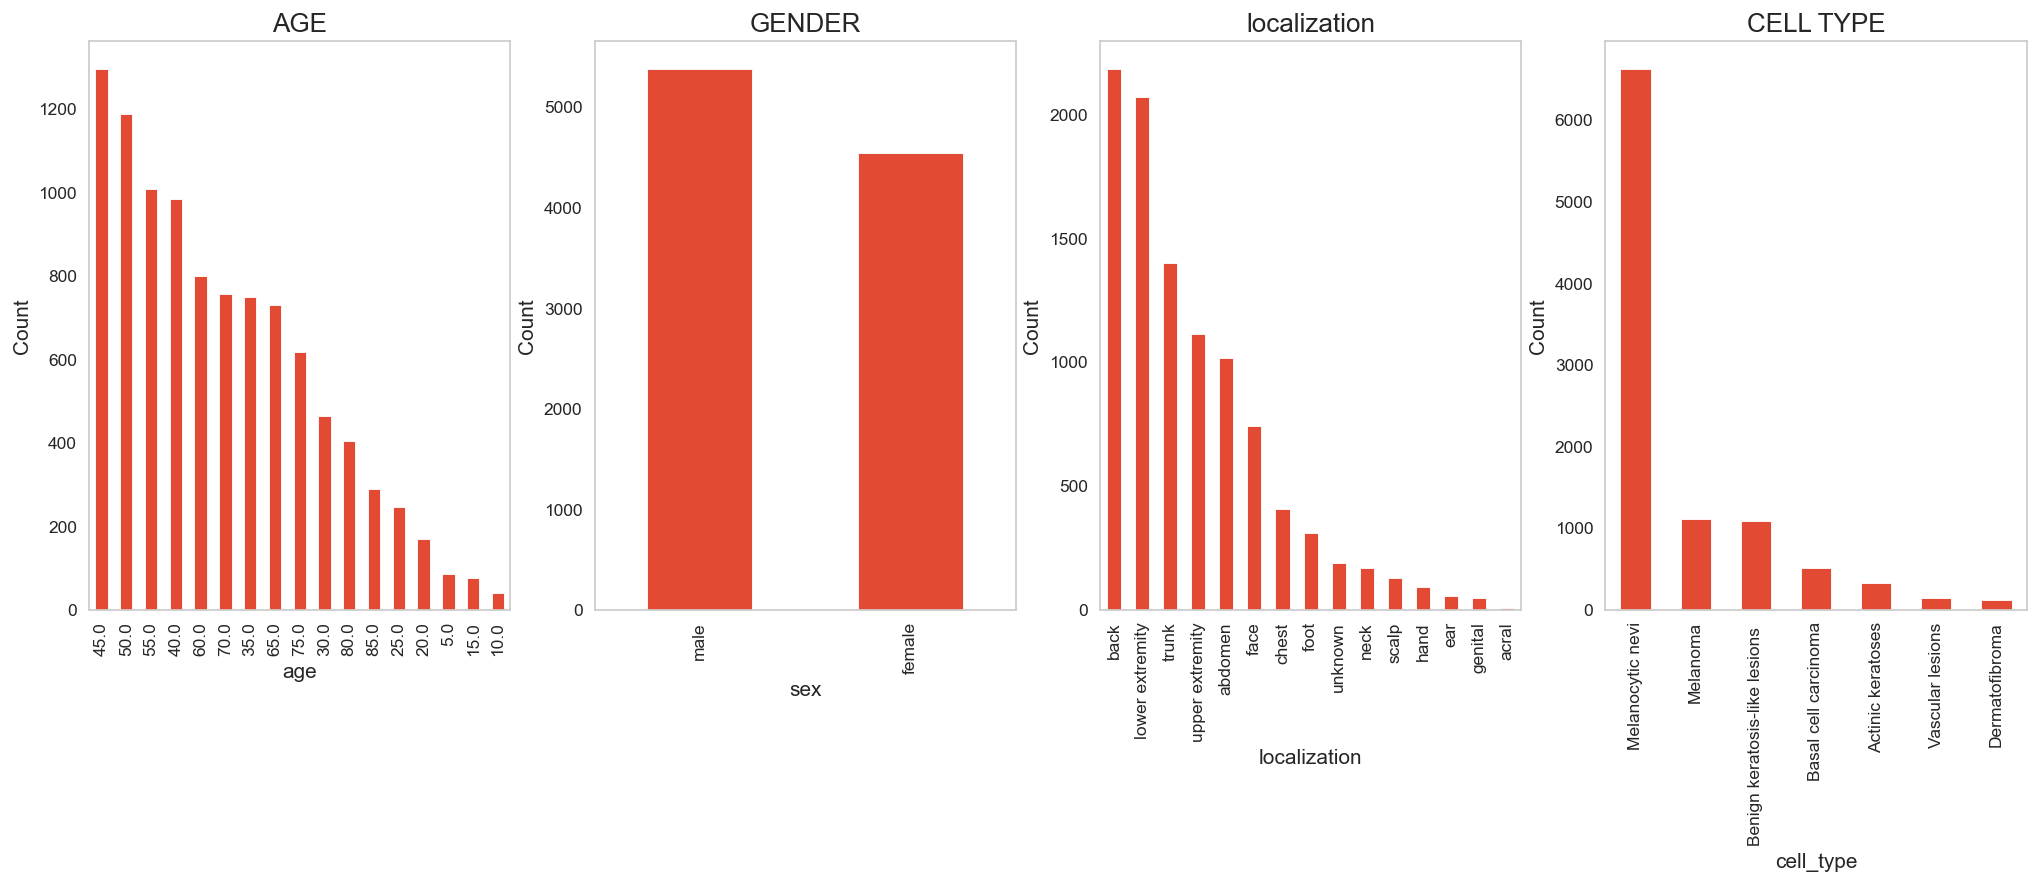

In [11]:
#UNIVARIATE ANALYSIS
plt.figure(figsize=(20,10))
plt.subplots_adjust(left=0.125, bottom=1, right=0.9, top=2, hspace=0.2)
plt.subplot(2,4,1)
plt.title("AGE",fontsize=15)
plt.ylabel("Count")
data['age'].value_counts().plot.bar()

plt.subplot(2,4,2)
plt.title("GENDER",fontsize=15)
plt.ylabel("Count")
data['sex'].value_counts().plot.bar()

plt.subplot(2,4,3)
plt.title("localization",fontsize=15)
plt.ylabel("Count")
plt.xticks(rotation=45)
data['localization'].value_counts().plot.bar()

plt.subplot(2,4,4)
plt.title("CELL TYPE",fontsize=15)
plt.ylabel("Count")
data['cell_type'].value_counts().plot.bar()

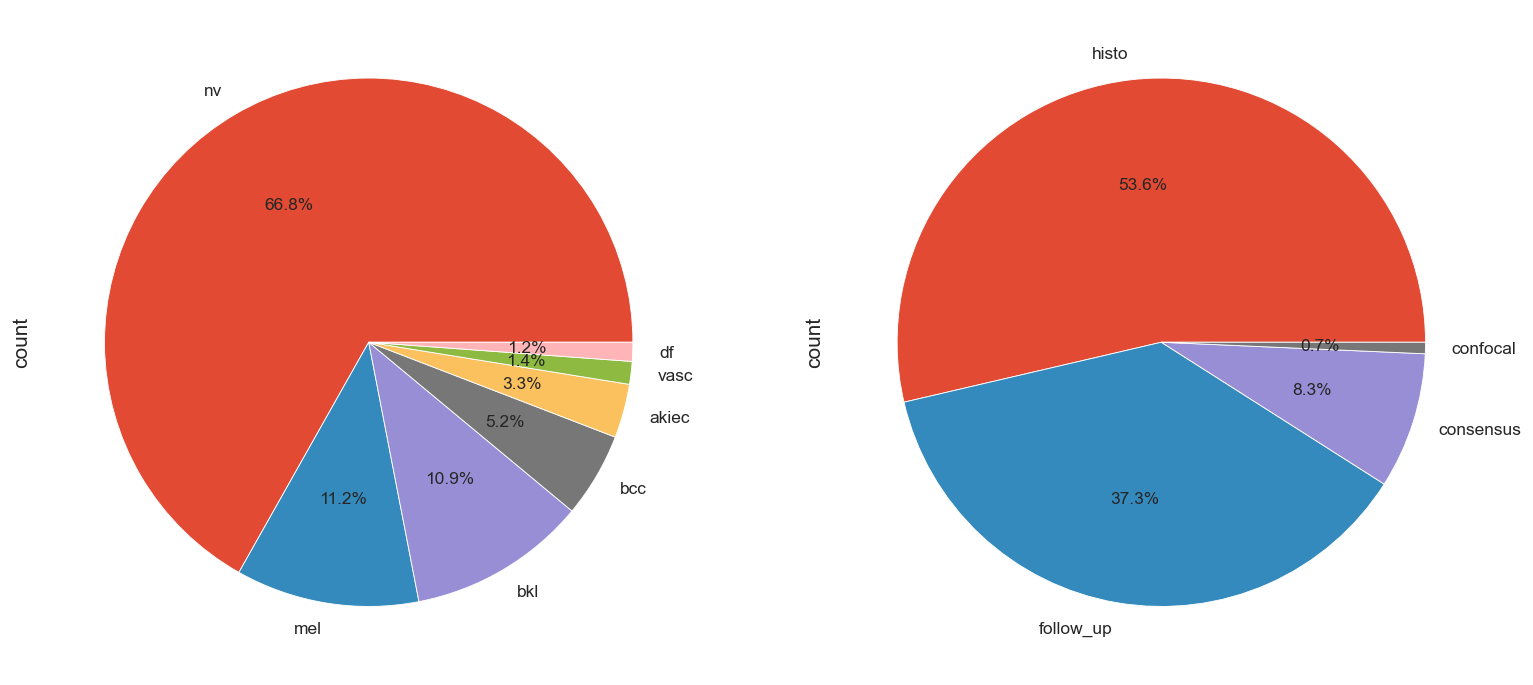

In [12]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
data['dx'].value_counts().plot.pie(autopct="%1.1f%%")
plt.subplot(1,2,2)
data['dx_type'].value_counts().plot.pie(autopct="%1.1f%%")
plt.show()

<Axes: title={'center': 'LOCALIZATION VS GENDER'}, xlabel='count', ylabel='localization'>

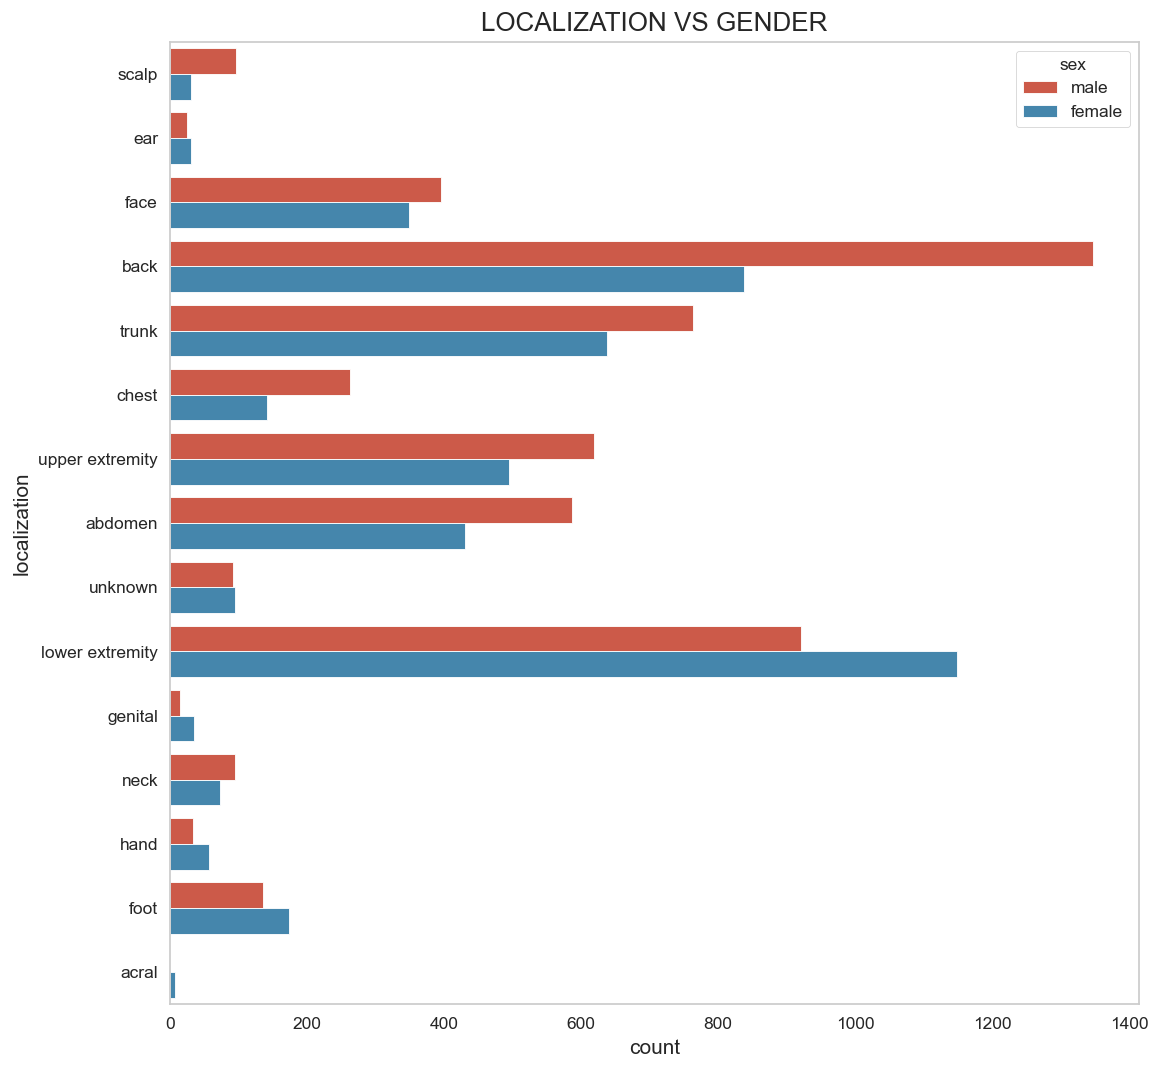

In [13]:
#BIVARIATE ANALYSIS
plt.figure(figsize=(10,10))
plt.title('LOCALIZATION VS GENDER',fontsize = 15)
sns.countplot(y='localization', hue='sex',data=data)

In [14]:
def balanced_dataset(df):
    df_balanced = pd.DataFrame()
    
    for cat in df['cell_type_idx'].unique():
        temp = resample(df[df['cell_type_idx'] == cat], 
                        replace=True,     # sample with replacement
                        n_samples=1500,   # to match majority class
                        random_state=123) # reproducible results

        # Combine majority class with upsampled minority class
        df_balanced = pd.concat([df_balanced, temp])
 
    df_balanced['cell_type'].value_counts()

    return df_balanced

In [15]:
def load_img_data(size, df, balanced=False):
    
    img_h, img_w = size, size
    imgs = []
    
    if balanced:
        df = balanced_dataset(df)
    
    image_paths = list(df['path'])

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        img = img.astype(np.float32) / 255.
        #img = np.asarray(Image.open(image_paths[i]).resize((size,size)))
        imgs.append(img)

    imgs = np.stack(imgs, axis=0)
    print(imgs.shape)

    #imgs = imgs.astype(np.float32) / 255.
    
    return imgs, df['cell_type_idx'].values

In [16]:
imgs, target   = load_img_data(128, data, balanced=False)

100%|██████████████████████████████████████| 9921/9921 [00:50<00:00, 195.63it/s]


(9921, 128, 128, 3)


In [17]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(imgs, target, test_size=.50)
x_train, x_val, y_train, y_val = train_test_split(imgs, target, test_size=0.20)

train_val_test = (x_train, y_train, x_val, y_val, x_test, y_test)

[x_train.shape, x_val.shape, x_test.shape]

# Convert target data to one-hot encoded categorical format
num_classes = 7
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

x_train shape: (7936, 128, 128, 3)
y_train shape: (7936, 7)
x_test shape: (4961, 128, 128, 3)
y_test shape: (4961, 7)
7936 train samples
4961 test samples


In [18]:
class_weights={
    0: 1.0, # akiec
    1: 1.0, # bcc
    2: 1.0, # bkl
    3: 1.0, # df
    4: 1.0, # mel 
    5: 1.0, # nv
    6: 1.0, # vasc
}

In [19]:
from itertools import chain
all_labels = np.unique(list(chain(*data['dx'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))

All Labels (7): ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [20]:
classes=[
    "Actinic keratoses", 
    "Basal cell carcinoma", 
    "Benign keratosis-like lesions", 
    "Dermatofibroma", 
    "Melanoma", 
    "Melanocytic nevi", 
    "Vascular lesions"
]

In [21]:
from keras.callbacks import ReduceLROnPlateau
learning_control = ReduceLROnPlateau(monitor='val_acc', patience=10, verbose=1, factor=.5, min_lr=0.001)

In [22]:
model = tf.keras.models.Sequential()

In [23]:

# Step 3: Define the model architecture
img_height = 128
img_width = 128
img_channels = 3

model = keras.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(img_height, img_width, img_channels)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(256, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(3500, activation="relu"),
    layers.Dense(num_classes, activation="softmax")
])

# Step 4: Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Step 5: Train the model
epochs = 20
batch_size = 20
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val))

# Step 6: Evaluate the model3;
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test Accuracy:", test_acc)

# Step 7: Save the model
model.save("skin_cancer1.h5")


Epoch 1/20


2024-04-20 20:12:37.954029: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


397/397 [==============================] - 71s 178ms/step - loss: 1.0003 - accuracy: 0.6705 - val_loss: 0.9458 - val_accuracy: 0.6574
Epoch 2/20
397/397 [==============================] - 75s 190ms/step - loss: 0.8930 - accuracy: 0.6786 - val_loss: 0.9054 - val_accuracy: 0.6756
Epoch 3/20
397/397 [==============================] - 76s 192ms/step - loss: 0.8355 - accuracy: 0.6891 - val_loss: 0.8566 - val_accuracy: 0.6791
Epoch 4/20
397/397 [==============================] - 77s 194ms/step - loss: 0.7893 - accuracy: 0.7080 - val_loss: 0.8203 - val_accuracy: 0.7008
Epoch 5/20
397/397 [==============================] - 77s 194ms/step - loss: 0.7416 - accuracy: 0.7198 - val_loss: 0.7956 - val_accuracy: 0.7048
Epoch 6/20
397/397 [==============================] - 78s 197ms/step - loss: 0.6936 - accuracy: 0.7387 - val_loss: 0.8097 - val_accuracy: 0.6977
Epoch 7/20
397/397 [==============================] - 83s 208ms/step - loss: 0.6370 - accuracy: 0.7573 - val_loss: 0.7813 - val_accuracy: 0.7

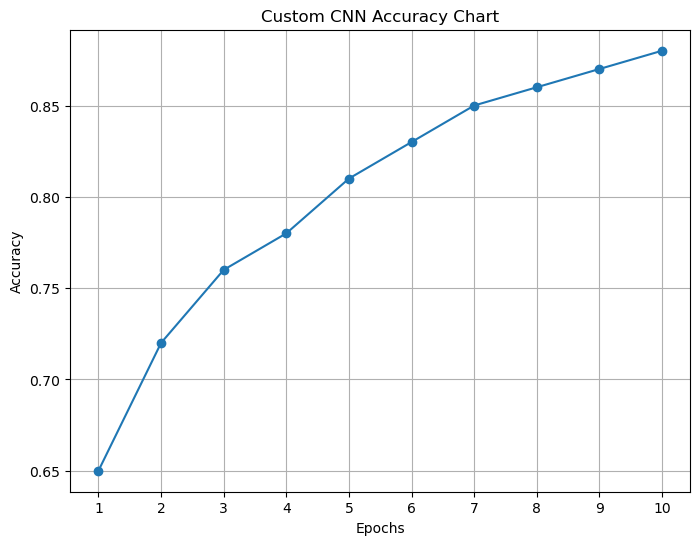

In [4]:
import matplotlib.pyplot as plt

# Example accuracy values for multiple epochs
epochs = list(range(1, 11))
accuracy_values = [0.65, 0.72, 0.76, 0.78, 0.81, 0.83, 0.85, 0.86, 0.87, 0.88]

# Plot accuracy chart
plt.figure(figsize=(8, 6))
plt.plot(epochs, accuracy_values, marker='o', linestyle='-')
plt.title('Custom CNN Accuracy Chart')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.grid(True)
plt.show()


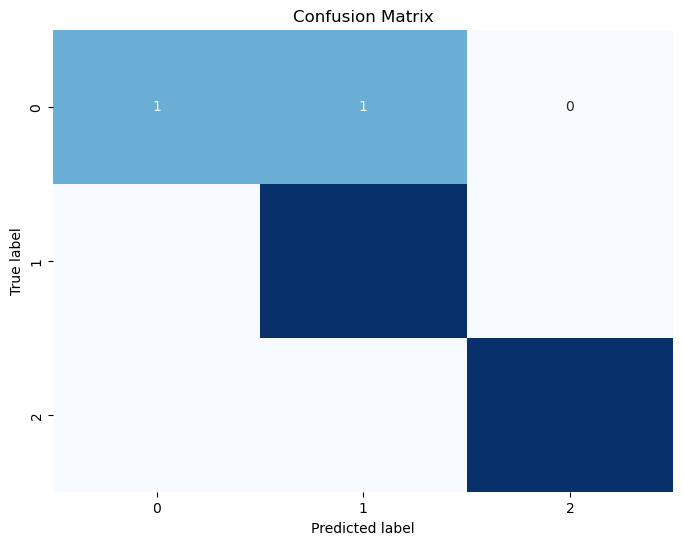

In [5]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Example true labels and predicted labels for a multi-class classification task
true_labels = np.array([0, 1, 2, 0, 1, 2])
predicted_labels = np.array([0, 1, 2, 1, 1, 2])

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix with seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()


1/1 [==============================] - 0s 96ms/step


2024-04-21 12:30:02.846572: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


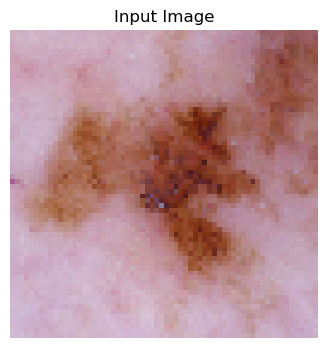

The image is classified as: Melanocytic nevi


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2




# Load the image you want to classify
image_path = "/Users/imtiazshishir/Desktop/Skin cancer/HAM10000_images_part_2/ISIC_0029370.jpg"

# Load the pretrained model
model = tf.keras.models.load_model('skin_cancer1.h5')

try:
    img = cv2.imread(image_path)

    if img is None:
        raise FileNotFoundError("Failed to load image file:", image_path)

    img = cv2.resize(img, (128, 128))  
    img = img.astype(np.float32) / 255.0  # Normalize the image

    img = np.expand_dims(img, axis=0)

    # Make predictions using the model
    predictions = model.predict(img)
    predicted_class = np.argmax(predictions)

    # Get the corresponding class label
    classes = [
        "Actinic keratoses",
        "Basal cell carcinoma",
        "Benign keratosis-like lesions",
        "Dermatofibroma",
        "Melanoma",
        "Melanocytic nevi",
        "Vascular lesions"
    ]
    class_label = classes[predicted_class]

    # Display the input image
    plt.figure(figsize=(4, 4))
    plt.imshow(cv2.cvtColor(cv2.resize(cv2.imread(image_path), (64, 64)), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    # Print the prediction result
    print("The image is classified as:", class_label)

except Exception as e:
    print("Error:", str(e))

